In [9]:
# Training and Test

# Hierarchical Bayes Part-Worth Estimation and Study of Consumer Preferences

# BASED ON MILLER (2015)

# analysis guided by ternary model of consumer preference and market response
# brand loyalty... price sensitivity... and feature focus... are key aspects
# to consider in determining pricing policy

library(lattice)  # package for lattice graphics 
library(vcd)  # graphics package with mosaic plots for mosaic and ternary plots
library(ggplot2)  # package ggplot implements Grammar of Graphics approach
library(ChoiceModelR)  # for Hierarchical Bayes Estimation
library(caret)  # for confusion matrix... evaluation of choice set predictions

# load split-plotting utilities for work with ggplot
load("mtpa_split_plotting_utilities.Rdata")

# load market simulation utilities 
load(file="mtpa_market_simulation_utilities.RData")

Warning message:
"package 'e1071' was built under R version 3.4.2"

In [10]:
# read in the data from a case study in computer choice.
complete.data.frame <- read.csv("computer_choice_study.csv")

print.digits <- 2
# user-defined function for printing conjoint measures
if (print.digits == 2) 
  pretty.print <- function(x) {sprintf("%1.2f",round(x,digits = 2))} 
if (print.digits == 3) 
  pretty.print <- function(x) {sprintf("%1.3f",round(x,digits = 3))} 
 
# set up sum contrasts for effects coding
options(contrasts=c("contr.sum","contr.poly"))

In [11]:
# employ a training-and-test regimen across survey sets/items 
test.set.ids <- c("3","7","11","15")  # select four sets/items
training.set.ids <- setdiff(unique(complete.data.frame$setid),test.set.ids)
training.data.frame <- 
  subset(complete.data.frame,subset=(setid %in% training.set.ids))
test.data.frame <- 
  subset(complete.data.frame,subset=(setid %in% test.set.ids))

UniqueID <- unique(training.data.frame$id)
# set up zero priors
cc.priors <- matrix(0,nrow=length(UniqueID),ncol=13) 

# we could use coefficients from aggregate model as starting values
# here we comment out the code needed to do that
# aggregate.cc.betas <- c(as.numeric(conjoint.results$coefficients)[2:7],
#  -sum(as.numeric(conjoint.results$coefficients)[2:7]),
#  as.numeric(conjoint.results$coefficients)[8:13])
# clone aggregate part-worths across the individuals in the study
# set up Bayesian priors
# cc.priors <- matrix(0,nrow=length(UniqueID),ncol=length(aggregate.cc.betas)) 
# for(index.for.ID in seq(along=UniqueID))
# cc.priors[index.for.ID,] <- aggregate.cc.betas

colnames(cc.priors) <- c("A1B1","A1B2","A1B3","A1B4","A1B5","A1B6","A1B7",
  "A1B8","A2B1","A3B1","A4B1","A5B1","A6B1")

# note that the actual names are as follows: 
AB.names <- c("Apple","Compaq","Dell","Gateway","HP","IBM","Sony","Sun",
  "Compatibility","Performance","Reliability","Learning","Price")

# set up run parameters for the MCMC
# using aggregate beta estimates to get started
truebetas <- cc.priors
cc.xcoding <- c(0,1,1,1,1,1)  # first variable categorical others continuous
cc.attlevels <- c(8,8,4,2,8,8) # test run with all attributes and levels

In [12]:
# no constraint for order on brand so 8x8 matrix of zeroes
c1 <- matrix(0,ncol=8,nrow=8)

# compatibility is ordered higher numbers are better
# continuous attributes have 1x1 matrix representation
c2 <- matrix(1, ncol = 1, nrow = 1, byrow = TRUE)

# performance is ordered higher numbers are better
# continuous attributes have 1x1 matrix representation
c3 <- matrix(1, ncol = 1, nrow = 1, byrow = TRUE)

# reliability is ordered higher numbers are better
# continuous attributes have 1x1 matrix representation
c4 <- matrix(1, ncol = 1, nrow = 1, byrow = TRUE)

# learning has expected order... higher learning times less valued
# continuous attributes have 1x1 matrix representation
c5 <- matrix(-1, ncol = 1, nrow = 1, byrow = TRUE)

# price has expected order... higher prices less valued
# continuous attributes have 1x1 matrix representation
c6 <- matrix(-1, ncol = 1, nrow = 1, byrow = TRUE)

cc.constraints <- list(c1,c2,c3,c4,c5,c6)

# controls for length of run and sampling from end of run
# cc.mcmc <- list(R = 10, use = 10) # fast trial run
# set run parameters 10000 total iterations with estimates based on last 2000
cc.mcmc <- list(R = 10000, use = 2000) # run parameters

# run options
cc.options <- list(none=FALSE, save=TRUE, keep=1)


In [13]:

# set up the data frame for analysis
# redefine set ids so they are a complete set 1-12 as needed for HB functions
training.data.frame$newsetid <- training.data.frame$setid
training.data.frame$newsetid <- ifelse((training.data.frame$newsetid == 16),
  3,training.data.frame$newsetid)
training.data.frame$newsetid <- ifelse((training.data.frame$newsetid == 14),
  7,training.data.frame$newsetid)
training.data.frame$newsetid <- ifelse((training.data.frame$newsetid == 13),
  11,training.data.frame$newsetid)

UnitID <- training.data.frame$id
Set <- as.integer(training.data.frame$newsetid)
Alt <- as.integer(training.data.frame$position)
X_1 <- as.integer(training.data.frame$brand) # categories by brand
X_2 <- as.integer(training.data.frame$compat)  # integer values 1 to 8
X_3 <- as.integer(training.data.frame$perform)  # integer values 1 to 4
X_4 <- as.integer(training.data.frame$reliab)  # integer values 1 to 2
X_5 <- as.integer(training.data.frame$learn)  # integer values 1 to 8
X_6 <- as.integer(training.data.frame$price)  # integer values 1 to 8
y <- as.numeric(training.data.frame$choice)  # using special response coding

cc.data <- data.frame(UnitID,Set,Alt,X_1,X_2,X_3,X_4,X_5,X_6,y)

                    Logit Data                    
Attribute       Type         Levels
-----------------------------------
Attribute 1    Part Worth      8
Attribute 2    Linear          1
Attribute 3    Linear          1
Attribute 4    Linear          1
Attribute 5    Linear          1
Attribute 6    Linear          1

12 parameters to be estimated.

224 total units.
Average of 4 alternatives in each of 12 sets per unit.
2688 expanded tasks in total.

Table of choice data pooled across units:
Choice  Count   Pct.
--------------------
   1    746    27.75%
   2    872    32.44%
   3    507    18.86%
   4    563    20.94%

      MCMC Inference for Hierarchical Logit       
Total Iterations:          10000
Draws used in estimation:  2000
Units:                     224
Parameters per unit:       12
Task weight:               5
Constraints in effect.
Draws are to be saved.
Prior degrees of freedom:  5
Prior variance:            2

MCMC Iteration Beginning...
Iteration  Acceptance   RLH    

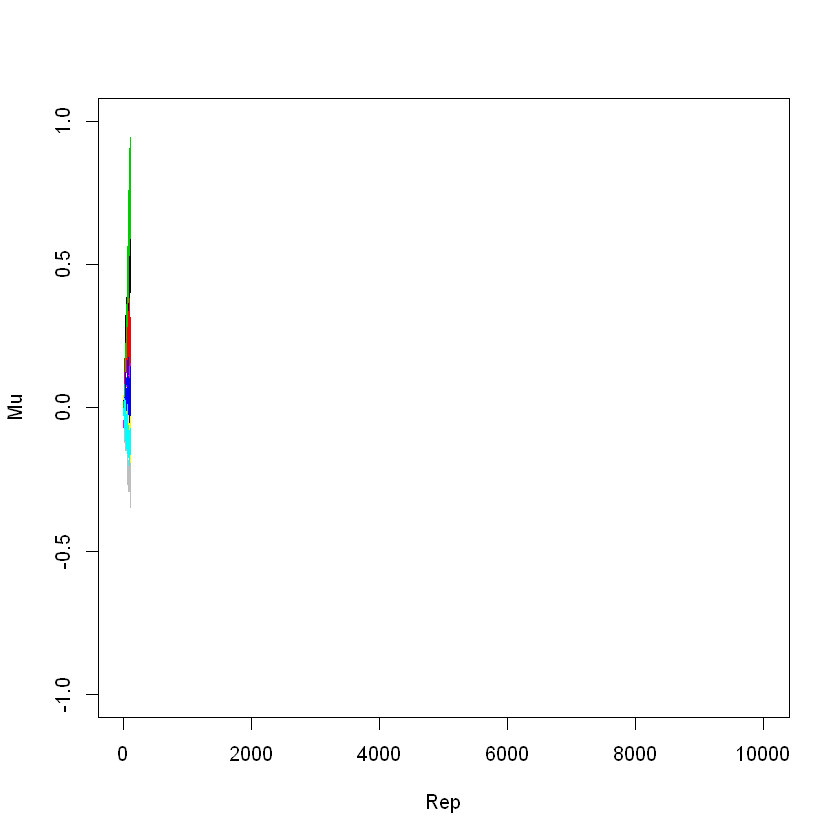

      200  0.305        0.570   0.561        1.15        0.96    1:24  


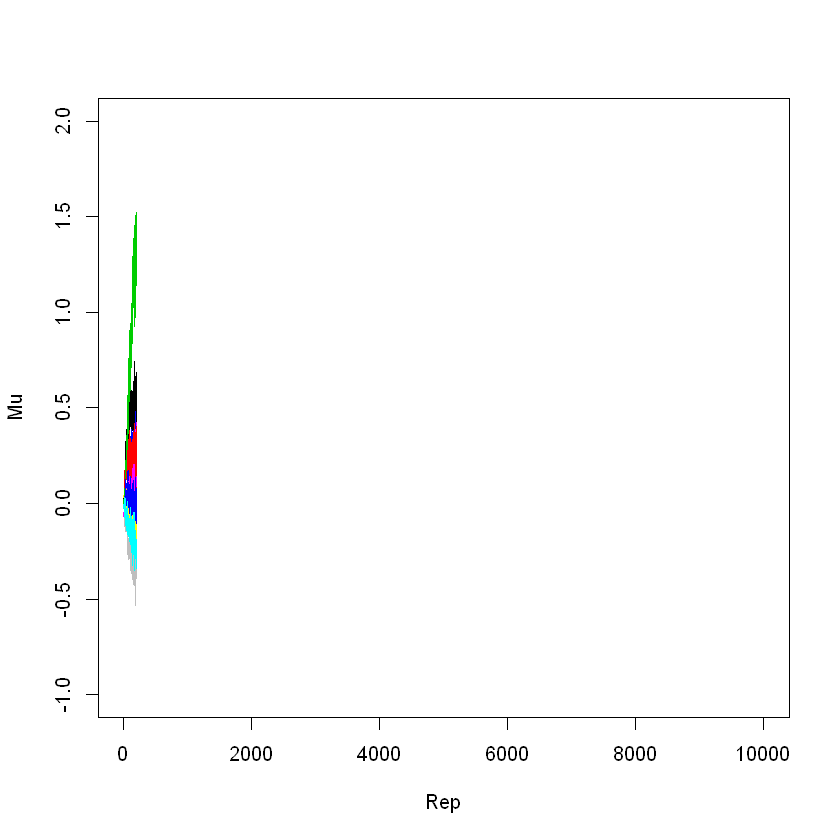

      300  0.307        0.665   0.689        2.39        1.52    1:19  
      400  0.303        0.717   0.752        3.64        1.96    1:14  
      500  0.305        0.746   0.785        5.31        2.40    1:11  


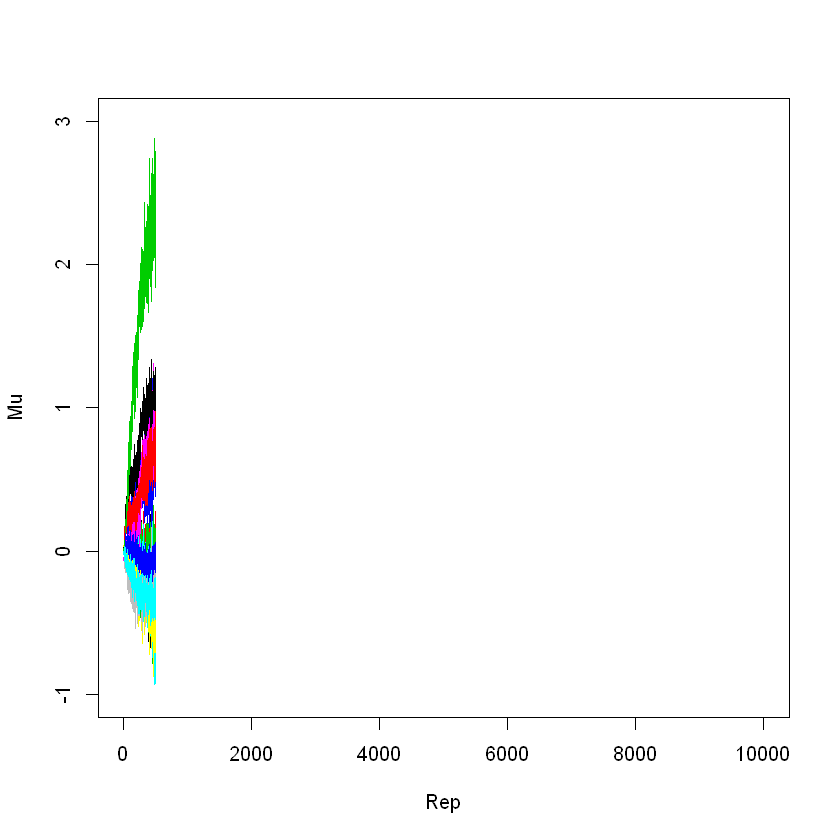

      600  0.308        0.764   0.805        6.87        2.75    1:10  
      700  0.311        0.778   0.818        8.40        3.05    1:08  
      800  0.304        0.787   0.827        10.20       3.38    1:06  


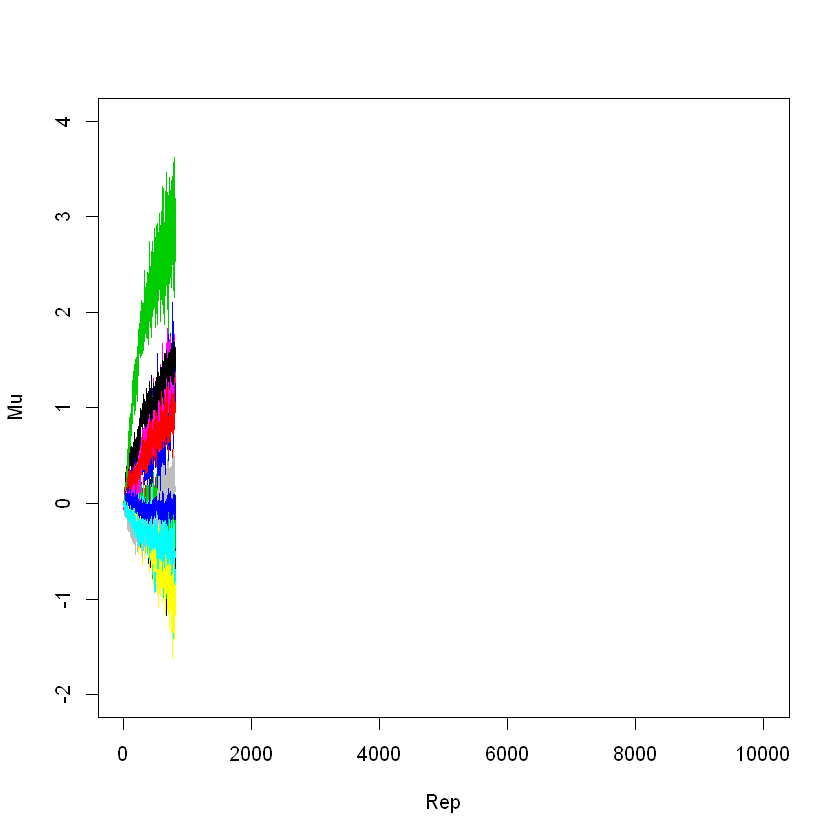

      900  0.308        0.794   0.833        11.69       3.64    1:06  


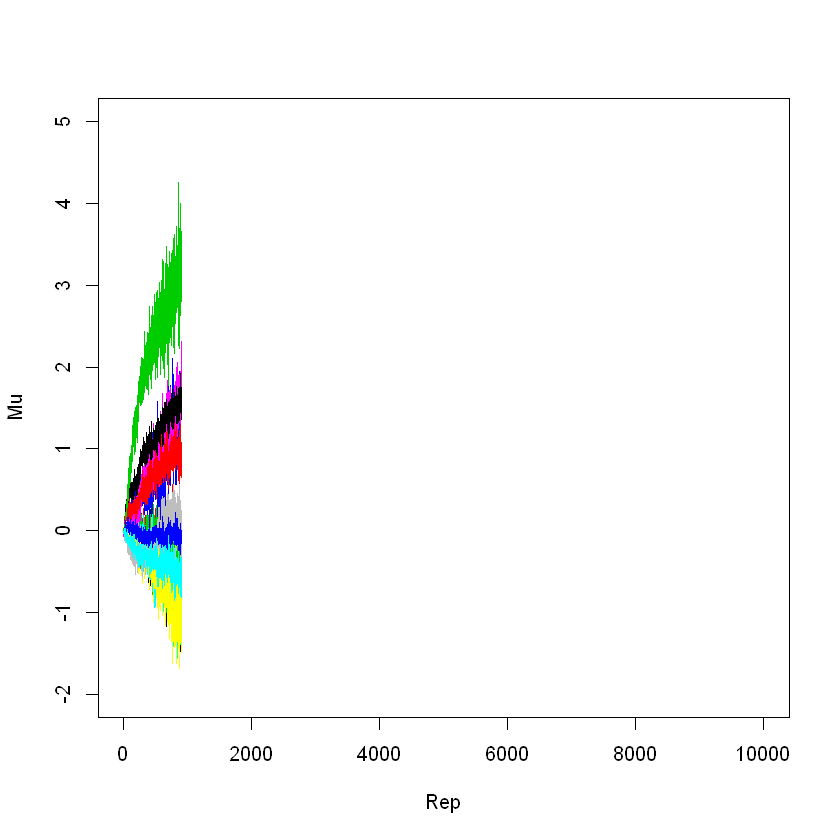

     1000  0.305        0.798   0.837        13.47       3.92    1:06  
     1100  0.306        0.802   0.841        15.82       4.25    1:04  


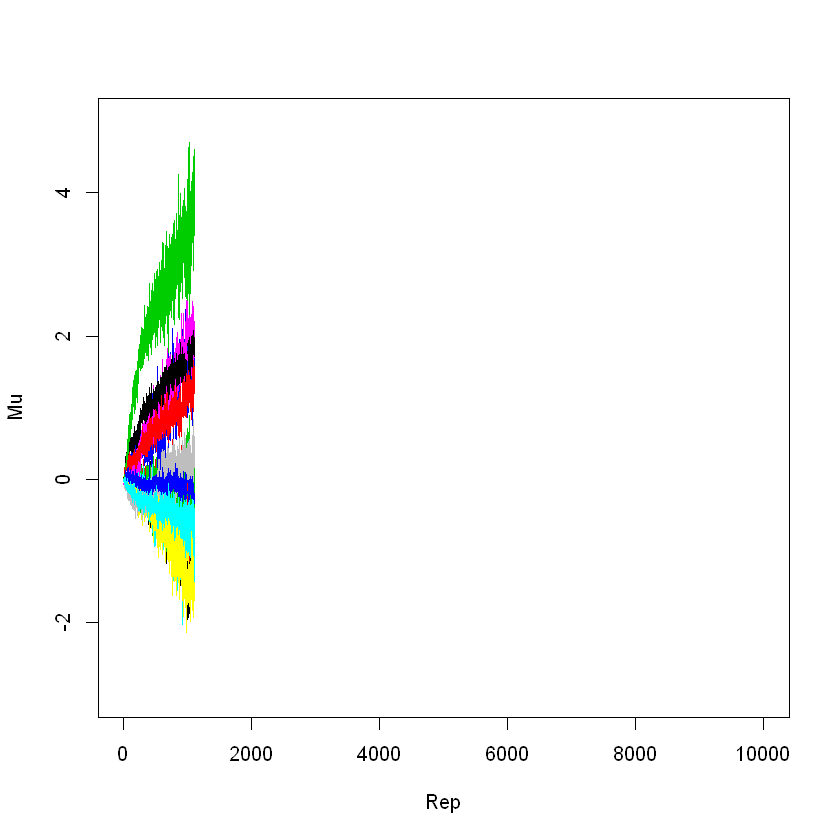

     1200  0.302        0.806   0.844        17.52       4.49    1:05  
     1300  0.305        0.809   0.847        18.58       4.62    1:04  
     1400  0.310        0.811   0.849        20.29       4.84    1:02  
     1500  0.306        0.815   0.852        22.46       5.10    1:02  
     1600  0.310        0.816   0.854        23.57       5.21    1:00  
     1700  0.306        0.817   0.854        24.63       5.33    0:59  


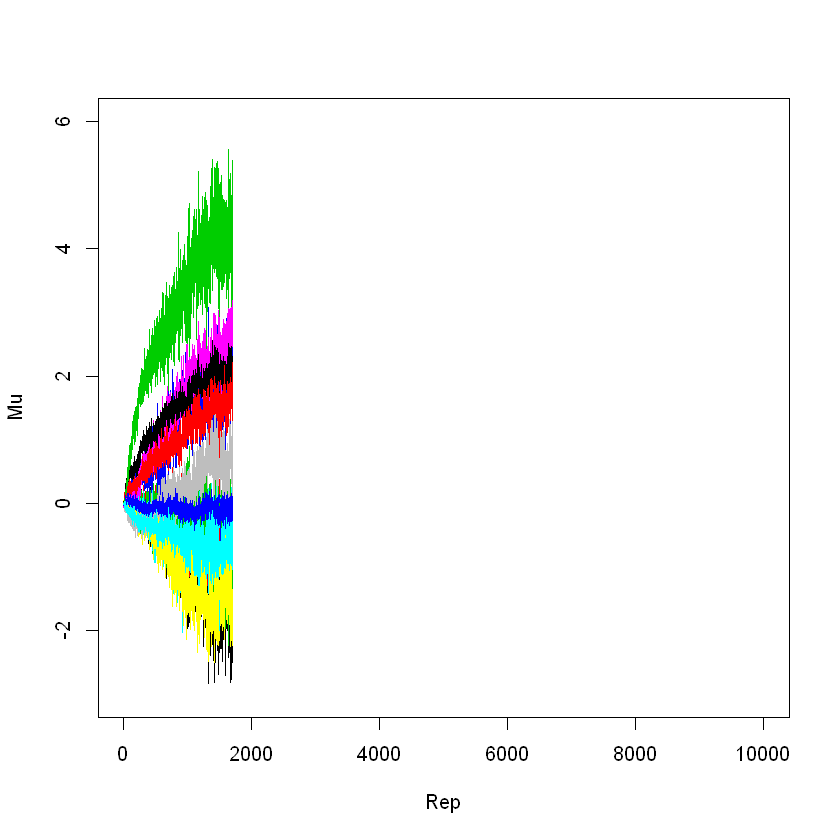

     1800  0.306        0.818   0.855        25.47       5.41    0:59  


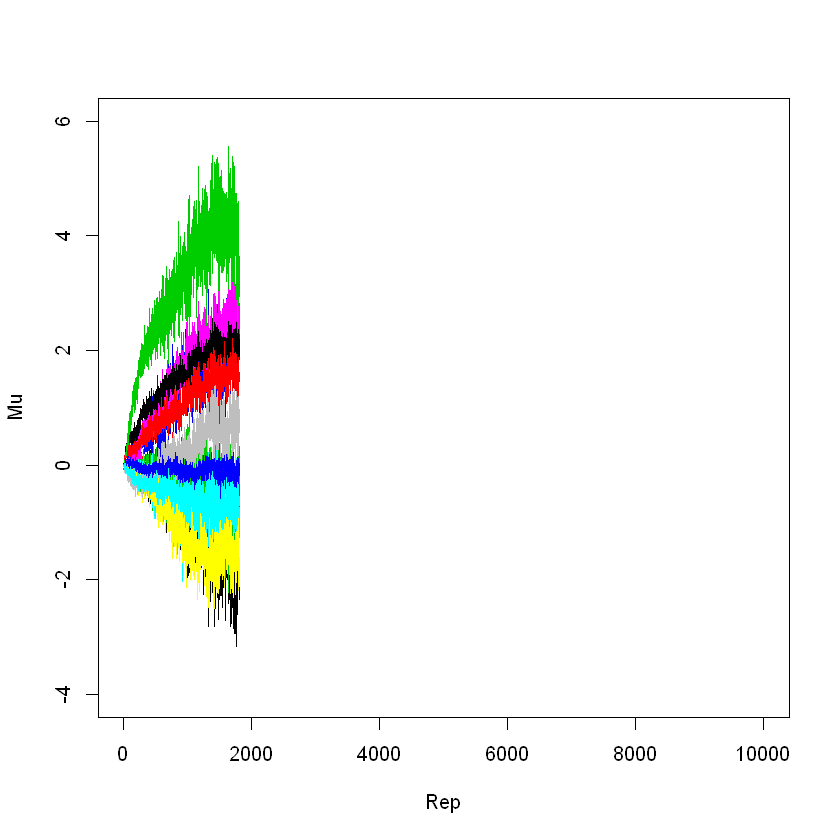

     1900  0.312        0.819   0.856        26.30       5.52    0:59  
     2000  0.306        0.821   0.857        27.36       5.62    0:58  
     2100  0.302        0.821   0.858        28.05       5.66    0:57  
     2200  0.303        0.822   0.858        30.54       5.90    0:56  
     2300  0.306        0.822   0.859        31.87       6.02    0:55  
     2400  0.304        0.823   0.860        32.73       6.14    0:54  
     2500  0.304        0.824   0.861        34.64       6.30    0:53  
     2600  0.302        0.826   0.862        35.99       6.41    0:52  
     2700  0.308        0.827   0.863        37.58       6.53    0:51  


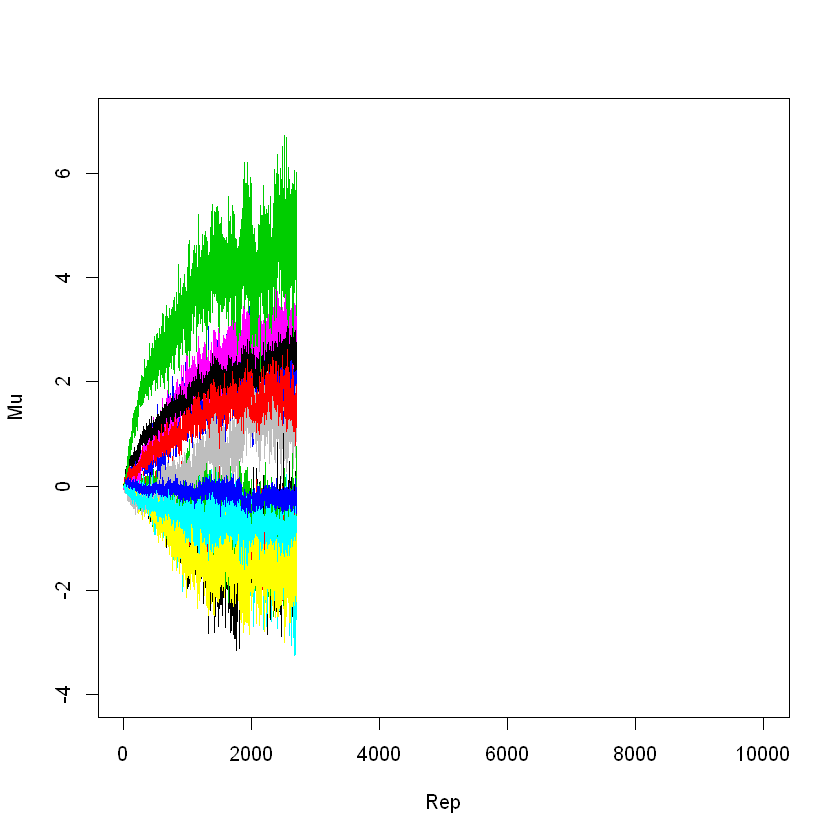

     2800  0.303        0.827   0.863        39.48       6.70    0:51  
     2900  0.304        0.829   0.864        42.10       6.95    0:50  


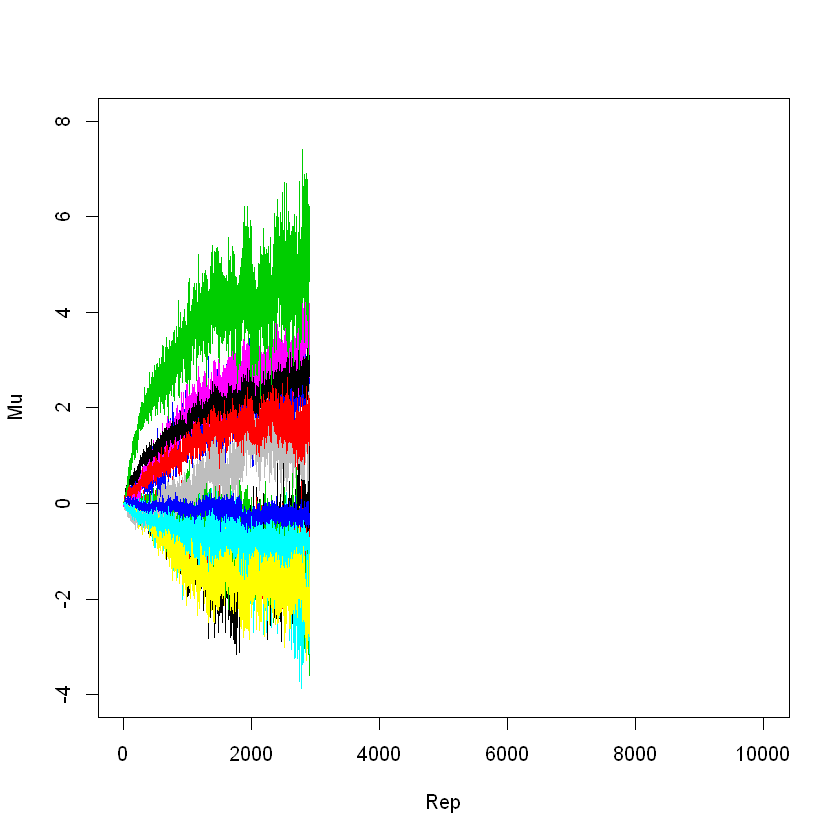

     3000  0.303        0.828   0.864        43.81       7.10    0:50  
     3100  0.298        0.829   0.864        44.41       7.17    0:49  
     3200  0.302        0.830   0.865        45.20       7.23    0:48  
     3300  0.305        0.830   0.866        44.69       7.20    0:48  
     3400  0.305        0.832   0.867        45.87       7.27    0:47  
     3500  0.307        0.832   0.867        47.70       7.42    0:46  
     3600  0.308        0.832   0.867        49.01       7.54    0:45  
     3700  0.307        0.832   0.868        50.25       7.62    0:44  
     3800  0.307        0.832   0.867        50.75       7.65    0:43  


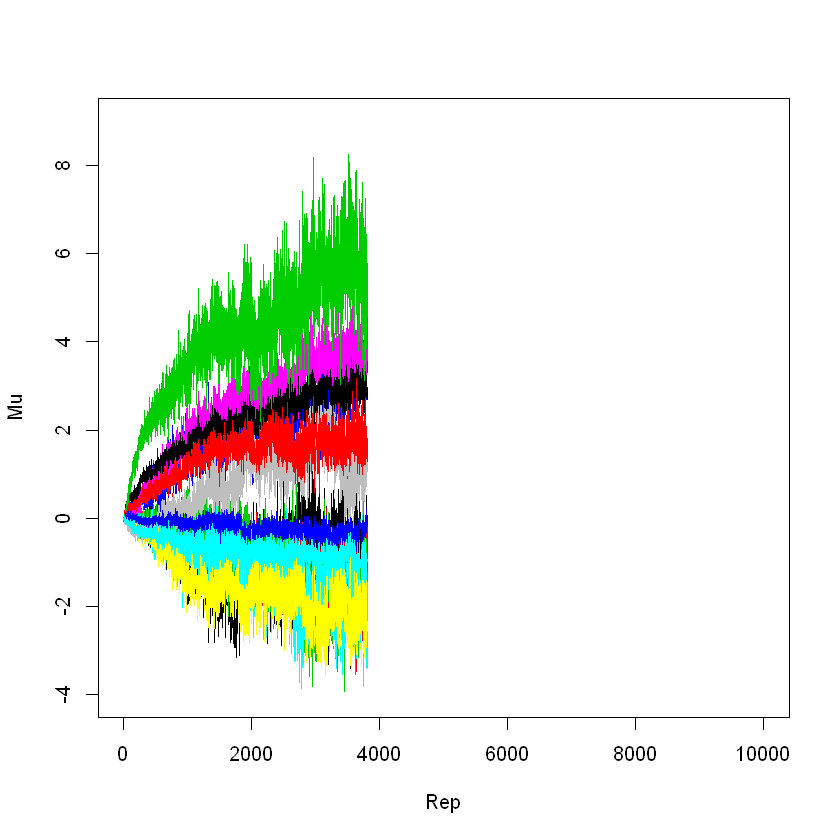

     3900  0.306        0.833   0.868        51.00       7.66    0:44  
     4000  0.304        0.833   0.868        51.83       7.70    0:43  
     4100  0.306        0.833   0.869        54.25       7.86    0:42  
     4200  0.303        0.835   0.870        54.55       7.90    0:41  
     4300  0.303        0.835   0.870        54.47       7.91    0:40  
     4400  0.304        0.835   0.870        55.56       8.01    0:39  
     4500  0.303        0.835   0.870        57.28       8.14    0:39  
     4600  0.304        0.836   0.871        57.41       8.12    0:38  
     4700  0.301        0.836   0.871        57.84       8.17    0:37  
     4800  0.304        0.837   0.872        60.85       8.39    0:36  
     4900  0.300        0.836   0.871        59.78       8.36    0:35  
     5000  0.306        0.836   0.871        59.02       8.28    0:35  
     5100  0.309        0.837   0.871        59.96       8.36    0:34  
     5200  0.301        0.837   0.871        62.16       8.50   

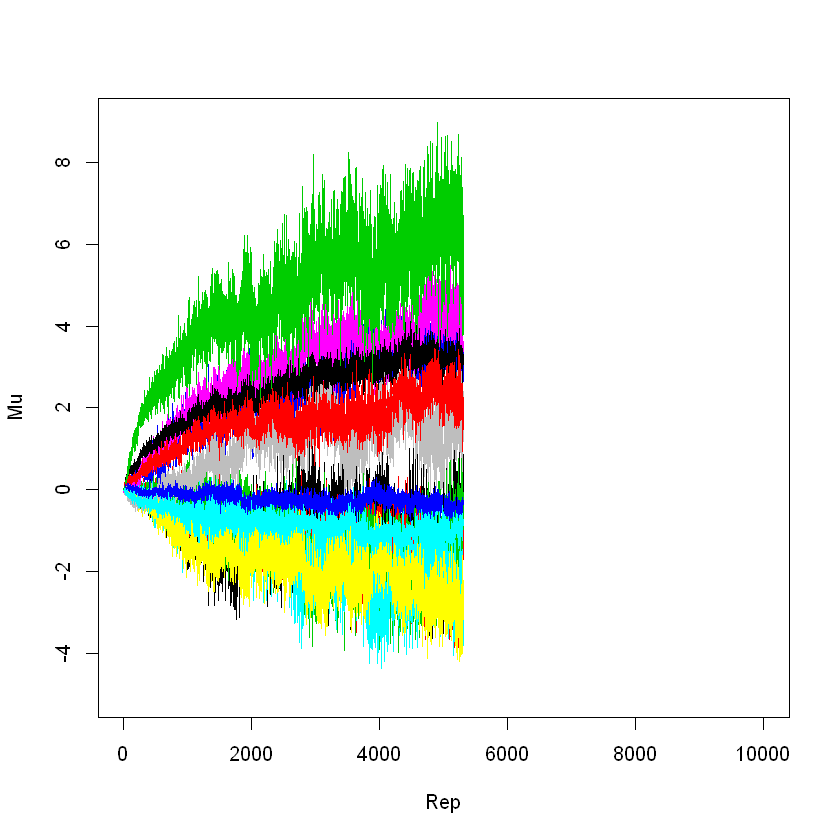

     5400  0.301        0.835   0.870        59.05       8.26    0:32  
     5500  0.304        0.835   0.870        58.30       8.21    0:31  
     5600  0.308        0.836   0.871        59.58       8.28    0:31  
     5700  0.303        0.836   0.871        60.43       8.33    0:30  
     5800  0.306        0.837   0.872        61.17       8.42    0:29  
     5900  0.304        0.836   0.871        62.82       8.53    0:28  
     6000  0.297        0.836   0.871        64.02       8.61    0:28  
     6100  0.305        0.837   0.872        63.46       8.59    0:27  
     6200  0.305        0.837   0.871        63.39       8.60    0:26  
     6300  0.309        0.837   0.872        64.17       8.68    0:26  
     6400  0.303        0.838   0.873        65.03       8.73    0:25  
     6500  0.300        0.838   0.872        66.64       8.83    0:24  


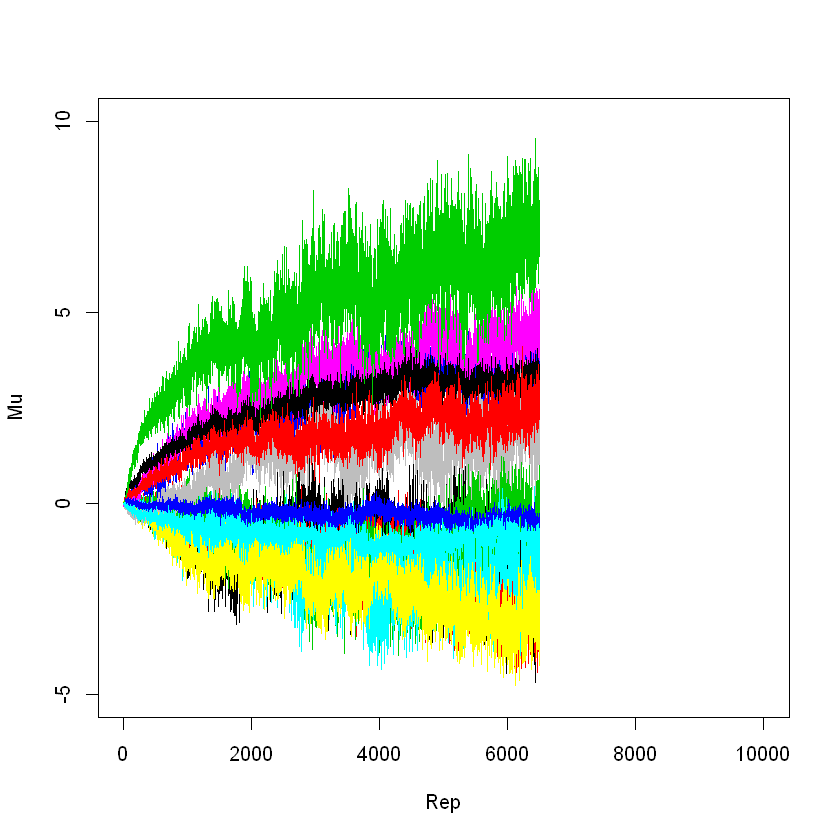

     6600  0.303        0.838   0.873        66.28       8.82    0:24  
     6700  0.302        0.839   0.873        65.92       8.82    0:23  
     6800  0.309        0.839   0.873        66.27       8.82    0:22  
     6900  0.306        0.839   0.873        64.31       8.66    0:22  
     7000  0.309        0.838   0.873        61.09       8.42    0:21  
     7100  0.306        0.838   0.872        59.40       8.32    0:20  
     7200  0.302        0.838   0.872        60.36       8.39    0:19  
     7300  0.302        0.837   0.872        60.94       8.44    0:19  
     7400  0.302        0.838   0.872        59.93       8.36    0:18  
     7500  0.304        0.838   0.872        60.77       8.38    0:17  
     7600  0.303        0.837   0.872        60.98       8.40    0:17  
     7700  0.304        0.838   0.872        61.26       8.45    0:16  
     7800  0.313        0.838   0.873        61.15       8.47    0:15  
     7900  0.308        0.838   0.872        61.70       8.50   

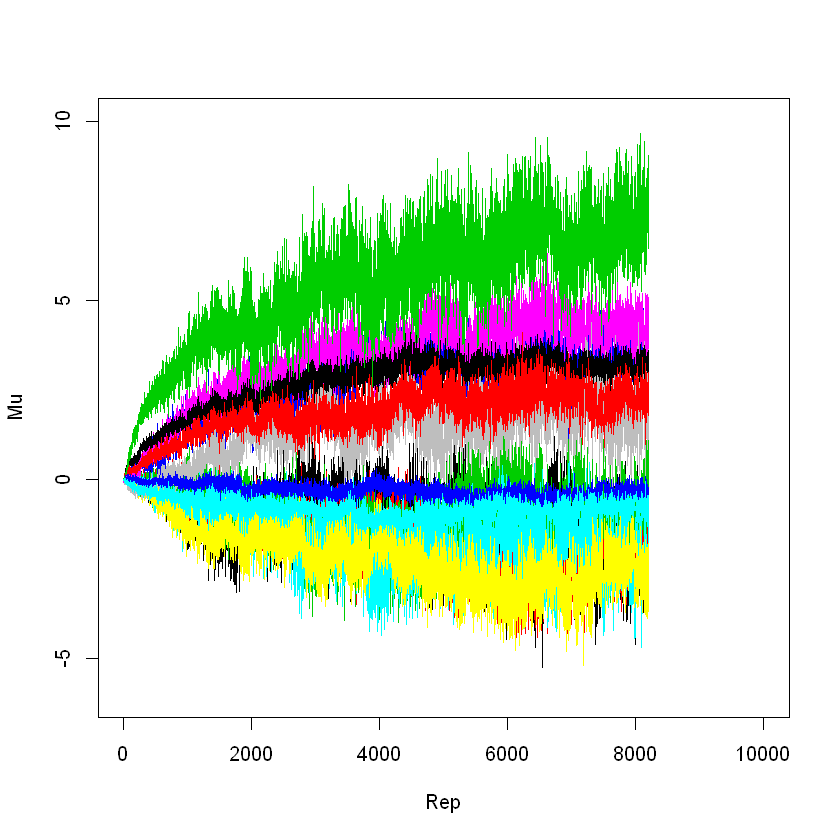

     8300  0.299        0.840   0.874        66.20       8.83    0:12  
     8400  0.311        0.840   0.875        67.24       8.87    0:11  
     8500  0.306        0.840   0.875        68.29       8.93    0:10  
     8600  0.310        0.840   0.874        67.27       8.86    0:10  
     8700  0.299        0.840   0.874        66.83       8.80    0:09  
     8800  0.304        0.840   0.874        68.46       8.88    0:08  
     8900  0.305        0.840   0.874        70.62       8.98    0:08  
     9000  0.308        0.839   0.874        69.66       8.94    0:07  
     9100  0.304        0.839   0.873        68.17       8.83    0:06  
     9200  0.308        0.839   0.874        67.17       8.78    0:06  
     9300  0.304        0.839   0.874        68.08       8.86    0:05  
     9400  0.304        0.840   0.874        70.94       9.04    0:04  
     9500  0.304        0.840   0.875        73.45       9.18    0:03  
     9600  0.302        0.840   0.874        75.90       9.33   

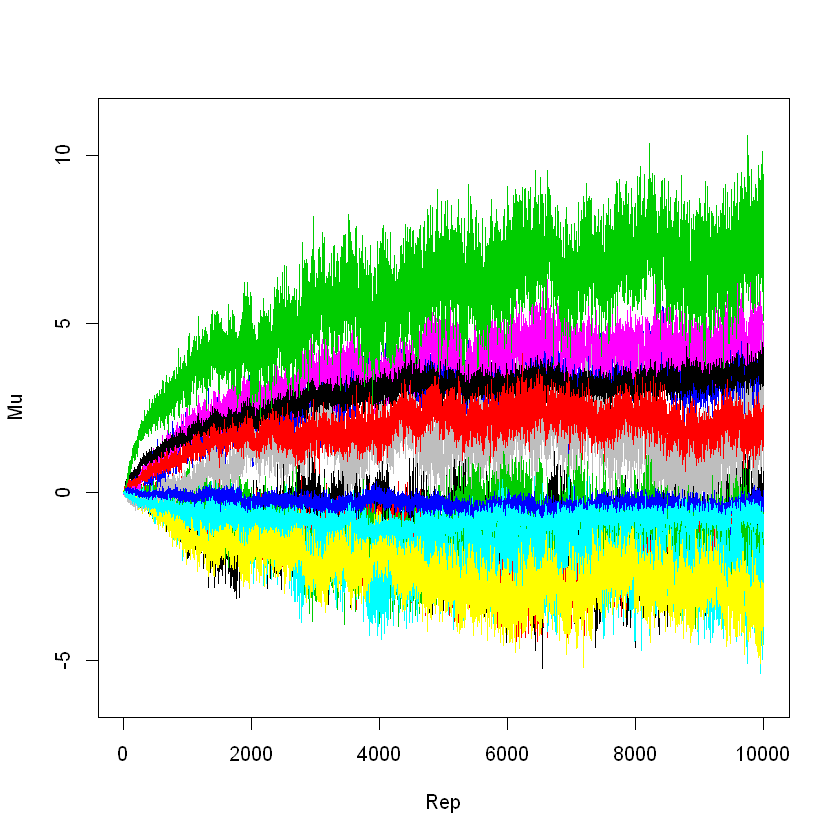

In [14]:
# now for the estimation... be patient
set.seed(9999)  # for reproducible results
out <- choicemodelr(data=cc.data, xcoding = cc.xcoding, 
  mcmc = cc.mcmc, options = cc.options, constraints = cc.constraints)

In [22]:

# out provides a list for the posterior parameter estimates 
# for the runs sampled (use = 2000)

# the MCMC beta parameter estimates are traced on the screen as it runs

# individual part-worth estimates are provided in the output file RBetas.csv
# the final estimates are printed to RBetas.csv with columns labeled as
#  A1B1 = first attribute first level
#  A1B2 = first attribute second level
#  ....
#  A2B1 = second attribute first level
#  ....
# gather data from HB posterior parameter distributions
# we imposed constraints on all continuous parameters so we use betadraw.c
posterior.mean <- matrix(0, nrow = dim(out$betadraw.c)[1], 
  ncol = dim(out$betadraw.c)[2])
posterior.sd <- matrix(0, nrow = dim(out$betadraw.c)[1], 
  ncol = dim(out$betadraw.c)[2])
for(index.row in 1:dim(out$betadraw.c)[1])
for(index.col in 1:dim(out$betadraw.c)[2]) { 
  posterior.mean[index.row,index.col] <- 
    mean(out$betadraw.c[index.row,index.col,])
  posterior.sd[index.row,index.col] <- 
    sd(out$betadraw.c[index.row,index.col,])
  }


In [16]:
# HB program uses effects coding for categorical variables and
# mean-centers continuous variables across the levels appearing in the data
# working with data for one respondent at a time we compute predicted choices
# for both the training and test choice sets

create.design.matrix <- function(input.data.frame.row) {
  xdesign.row <- numeric(12)
  if (input.data.frame.row$brand == "Apple") 
    xdesign.row[1:7] <- c(1,0,0,0,0,0,0)  
  if (input.data.frame.row$brand == "Compaq") 
    xdesign.row[1:7] <- c(0,1,0,0,0,0,0)  
  if (input.data.frame.row$brand == "Dell") 
    xdesign.row[1:7] <- c(0,0,1,0,0,0,0)  
  if (input.data.frame.row$brand == "Gateway") 
    xdesign.row[1:7] <- c(0,0,0,1,0,0,0)  
  if (input.data.frame.row$brand == "HP") 
    xdesign.row[1:7] <- c(0,0,0,0,1,0,0)  
  if (input.data.frame.row$brand == "IBM") 
    xdesign.row[1:7] <- c(0,0,0,0,0,1,0)  
  if (input.data.frame.row$brand == "Sony") 
    xdesign.row[1:7] <- c(0,0,0,0,0,0,1)  
  if (input.data.frame.row$brand == "Sun") 
    xdesign.row[1:7] <- c(-1,-1,-1,-1,-1,-1,-1)    
  
  xdesign.row[8] <- input.data.frame.row$compat -4.5 
  xdesign.row[9] <- input.data.frame.row$perform -2.5
  xdesign.row[10] <- input.data.frame.row$reliab -1.5 
  xdesign.row[11] <- input.data.frame.row$learn -4.5
  xdesign.row[12] <- input.data.frame.row$price -4.5 
  t(as.matrix(xdesign.row))  # return row of design matrix
  }

In [23]:
# evaluate performance in the training set
training.choice.utility <- NULL  # initialize utility vector
# work with one row of respondent training data frame at a time
# create choice prediction using the individual part-worths
list.of.ids <- unique(training.data.frame$id)
for (index.for.id in seq(along=list.of.ids)) {
  this.id.part.worths <- posterior.mean[index.for.id,] 
  this.id.data.frame <- subset(training.data.frame, 
    subset=(id == list.of.ids[index.for.id]))
  for (index.for.profile in 1:nrow(this.id.data.frame)) {   
    training.choice.utility <- c(training.choice.utility,
      create.design.matrix(this.id.data.frame[index.for.profile,]) %*%
      this.id.part.worths)
    }  
  }  

In [24]:
training.predicted.choice <- 
  choice.set.predictor(training.choice.utility)
training.actual.choice <- factor(training.data.frame$choice, levels = c(0,1), 
  labels = c("NO","YES"))  
# look for sensitivity > 0.25 for four-profile choice sets 
training.set.performance <- confusionMatrix(data = training.predicted.choice, 
  reference = training.actual.choice, positive = "YES")
# report choice prediction sensitivity for training data
cat("\n\nTraining choice set sensitivity = ",
  sprintf("%1.1f",training.set.performance$byClass[1]*100)," Percent",sep="")



Training choice set sensitivity = 93.7 Percent

In [19]:
# evaluate performance in the test set
test.choice.utility <- NULL  # initialize utility vector
# work with one row of respondent test data frame at a time
# create choice prediction using the individual part-worths
list.of.ids <- unique(test.data.frame$id)
for (index.for.id in seq(along=list.of.ids)) {
  this.id.part.worths <- posterior.mean[index.for.id,] 
  this.id.data.frame <- subset(test.data.frame, 
    subset=(id == list.of.ids[index.for.id]))
  for (index.for.profile in 1:nrow(this.id.data.frame)) {    
    test.choice.utility <- c(test.choice.utility,
      create.design.matrix(this.id.data.frame[index.for.profile,]) %*%
      this.id.part.worths)
    }  
  }  

test.predicted.choice <- 
  choice.set.predictor(test.choice.utility)
test.actual.choice <- factor(test.data.frame$choice, levels = c(0,1), 
  labels = c("NO","YES"))  
# look for sensitivity > 0.25 for four-profile choice sets 
test.set.performance <- confusionMatrix(data = test.predicted.choice, 
  reference = test.actual.choice, positive = "YES")
# report choice prediction sensitivity for test data
cat("\n\nTest choice set sensitivity = ",
  sprintf("%1.1f",test.set.performance$byClass[1]*100)," Percent",sep="")



Test choice set sensitivity = 52.6 Percent

    Additional Data / Graphs for Analysis - See Model Review - Bayesian Choice

In [20]:



# suggestions for students
# having demonstrated the predictive power of the HB model...
# return to the complete set of 16 choice sets to obtain 
# part-worths for individuals based upon the complete survey
# (the next program will provide guidance on how to do this)
# after estimating part-worths for individuals, average across
# individuals to obtain an aggregate profile of conjoint measures
# standardize the aggregate part-worths and display them
# on a spine chart using the spine chart plotting utility
# provided in the appendix of code and utilities
# interpret the spine chart, compare attribute importance values
# compare the brands, compute brand equity for each brand
# relative to each of the other brands in the study
